In [1]:
import os
import librosa
import pandas as pd


### Datasets apenas com features

In [2]:
def get_annotation_classes(folder_path):
    annotation_files = []
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            file_path = os.path.join(folder_path, file)
            annotation_files.append(file_path)

    classes = set()
    for file_path in annotation_files:
        file_name = os.path.basename(file_path)
        parts = file_name.split("_")
        if len(parts) > 1:
            annotation_class = parts[1].replace('.txt', '') # Retira a extensão .txt
            classes.add(annotation_class)

    return classes

In [3]:
def extract_annotations(folder_path, classes):
    data = []
    for annotation_class in classes:
        class_files = []
        for file in os.listdir(folder_path):
            if file.endswith(".txt") and annotation_class in file:
                file_path = os.path.join(folder_path, file)
                class_files.append(file_path)
        
        for file_path in class_files:
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        start_time = float(parts[0])
                        end_time = float(parts[1])
                        annotation_time = end_time - start_time
                        if len(parts) >= 3:
                            annotation = parts[2]
                            tag = parts[3] if len(parts) == 4 else ''
                            data.append({
                                'Classe': annotation_class,
                                'Duração': annotation_time,
                                'Anotação': annotation,
                                'Tag': tag,
                                'Início': start_time,
                                'Final': end_time,
                                "Filepath": file_path,
                                "Amostragem": 44_100
                            })

    df = pd.DataFrame(data)
    return df

In [4]:
folder_path = '../Datasets/VSD_2014_December_official_release/Hollywood-dev/annotations'  # Altere para o caminho da sua pasta de anotações
classes = get_annotation_classes(folder_path)
df_hollywood_dev = extract_annotations(folder_path, classes)


In [5]:
df_hollywood_dev

,Classe,Duração,Anotação,Tag,Início,Final,Filepath,Amostragem
0,fights,2318.0,distant,attack,21892.0,24210.0,../Datasets/VSD_2014_December_official_release...,44100
1,fights,111.0,small,,80536.0,80647.0,../Datasets/VSD_2014_December_official_release...,44100
2,fights,239.0,small,,111571.0,111810.0,../Datasets/VSD_2014_December_official_release...,44100
3,fights,61.0,1vs1,,111891.0,111952.0,../Datasets/VSD_2014_December_official_release...,44100
4,fights,106.0,small,,112721.0,112827.0,../Datasets/VSD_2014_December_official_release...,44100
...,...,...,...,...,...,...,...,...
27177,fire,31.0,sepia,,18292.0,18323.0,../Datasets/VSD_2014_December_official_release...,44100
27178,fire,45.0,sepia,,18540.0,18585.0,../Datasets/VSD_2014_December_official_release...,44100
27179,fire,41.0,sepia,,18588.0,18629.0,../Datasets/VSD_2014_December_official_release...,44100
27180,fire,583.0,sepia,,18645.0,19228.0,../Datasets/VSD_2014_December_official_release...,44100


### Datasets com Áudio

In [6]:
def extract_audio_info(folder):
    data = []
    for dirpath, dirnames, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.mp3'):
                file_path = os.path.join(dirpath, filename)
                duration = librosa.get_duration(path=file_path)
                sample_rate = librosa.get_samplerate(file_path)
                data.append([duration, file_path, sample_rate])
    df = pd.DataFrame(data, columns=['Duração', 'Filepath', 'Amostragem'])
    return df

In [7]:
# Função para organizar o dataframe com as colunas solicitadas
def organize_dataframe(df):
    df['Classe'] = ''
    df['Anotação'] = ''
    df['Tag'] = ''
    
    df['Início'] = ''
    df['Final'] = ''
    
    for i, row in df.iterrows():
        if 'HEAR Dataset' in row['Filepath'] and 'NAO_VIOLENCIA' in row['Filepath']:
            df.at[i, 'Classe'] = 'Violência Física'
            df.at[i, 'Anotação'] = '(nothing)'
        elif 'HEAR Dataset' in row['Filepath'] and 'VIOLENCIA' in row['Filepath']:
            df.at[i, 'Classe'] = 'Violência Física'
            df.at[i, 'Anotação'] = 'Violência Física'
        elif 'Gunshot Audio Forensic Dataset' in row['Filepath']:
            df.at[i, 'Classe'] = 'gunshots'
            df.at[i, 'Anotação'] = 'gunshot_forensic'
            df.at[i, 'Tag'] = os.path.basename(os.path.dirname(row['Filepath'])).replace('_Samsung', '')
        df.at[i, 'Início'] = 0
        df.at[i, 'Final'] = df.at[i, 'Duração']
    return df[['Classe', 'Duração', 'Anotação', 'Tag','Filepath', 'Início', 'Final', 'Amostragem']]


In [8]:
folder_path = '../Datasets'

df_audio_info = extract_audio_info(folder_path)

In [9]:
df_audio_info_organized = organize_dataframe(df_audio_info)

In [10]:
df_audio_info_organized

,Classe,Duração,Anotação,Tag,Filepath,Início,Final,Amostragem
0,gunshots,2.094833,gunshot_forensic,BoltAction22,../Datasets\Gunshot Audio Forensic Dataset\Bol...,0,2.094833,48000
1,gunshots,1.864542,gunshot_forensic,BoltAction22,../Datasets\Gunshot Audio Forensic Dataset\Bol...,0,1.864542,48000
2,gunshots,2.071938,gunshot_forensic,BoltAction22,../Datasets\Gunshot Audio Forensic Dataset\Bol...,0,2.071938,48000
3,gunshots,2.074187,gunshot_forensic,BoltAction22,../Datasets\Gunshot Audio Forensic Dataset\Bol...,0,2.074187,48000
4,gunshots,1.963313,gunshot_forensic,BoltAction22,../Datasets\Gunshot Audio Forensic Dataset\Bol...,0,1.963313,48000
...,...,...,...,...,...,...,...,...
73596,Violência Física,10.000000,Violência Física,,../Datasets\HEAR Dataset\AUDIO\media\tiago\EST...,0,10.0,16000
73597,Violência Física,10.000000,Violência Física,,../Datasets\HEAR Dataset\AUDIO\media\tiago\EST...,0,10.0,16000
73598,Violência Física,10.000000,Violência Física,,../Datasets\HEAR Dataset\AUDIO\media\tiago\EST...,0,10.0,16000
73599,Violência Física,10.000000,Violência Física,,../Datasets\HEAR Dataset\AUDIO\media\tiago\EST...,0,10.0,16000


### Agregando Datasets

In [11]:
df_concatenated = pd.concat([df_hollywood_dev, df_audio_info_organized], axis=0)


In [12]:
def aggregate_annotations(df):
    # Agrupando os dados por Classe e Anotação e realizando as agregações
    aggregated_df = df.groupby(['Classe', 'Anotação']).agg({
        'Duração': ['count', 'mean', 'median', 'std']
    }).reset_index()

    # Renomeando as colunas agregadas
    aggregated_df.columns = ['Classe', 'Anotação', 'Quantidade Total', 'Média da Duração', 'Mediana da Duração', 'Desvio Padrão']

    return aggregated_df

In [13]:
aggregated_df = aggregate_annotations(df_concatenated)

In [14]:
aggregated_df

,Classe,Anotação,Quantidade Total,Média da Duração,Mediana da Duração,Desvio Padrão
0,Violência Física,(nothing),36535,9.996247,10.000000,0.127032
1,Violência Física,Violência Física,35076,9.998791,10.000000,0.070684
2,blood,high,18,52.888889,21.000000,64.153207
3,blood,low,366,78.385246,43.000000,149.147942
4,blood,medium,56,95.946429,61.500000,124.496721
5,blood,unnoticeable,2194,67.113491,37.000000,111.517561
6,explosions,(nothing),1293,91.572931,3.060000,505.153427
7,explosions,explosion,621,1.464635,1.035202,1.419866
8,explosions,multiple_actions,552,2.551813,1.416628,3.677148
9,fights,1vs1,297,160.185185,78.000000,336.340655


In [15]:
aggregated_df.to_csv("dataset_analysis/dataset_analysis.csv")

In [16]:
# Defina a lista de classes desejadas
classes_desejadas = ['Violência Física', 'explosions', 'gunshots', 'screams']

# Filtrar o DataFrame para apenas as classes desejadas
df_filtrado = aggregated_df[aggregated_df['Classe'].isin(classes_desejadas)]

In [17]:
df_filtrado

,Classe,Anotação,Quantidade Total,Média da Duração,Mediana da Duração,Desvio Padrão
0,Violência Física,(nothing),36535,9.996247,10.000000,0.127032
1,Violência Física,Violência Física,35076,9.998791,10.000000,0.070684
6,explosions,(nothing),1293,91.572931,3.060000,505.153427
7,explosions,explosion,621,1.464635,1.035202,1.419866
8,explosions,multiple_actions,552,2.551813,1.416628,3.677148
40,gunshots,(nothing),1222,96.281201,1.868591,556.974981
41,gunshots,cannon_fire,143,0.621162,0.509503,0.443648
42,gunshots,gunshot,311,0.611567,0.459981,0.468471
43,gunshots,gunshot_forensic,1990,2.014234,2.011198,0.096687
44,gunshots,multiple_actions,674,2.902545,1.473686,3.973856


In [26]:
# Lista de anotações de classes consideradas como não-violentos
anotacoes_nao_violentos = ['(nothing)', 'scream_effort', 'multiple_actions_scream_effort']


# Cria uma cópia do DataFrame original
df_filtrado_copy = df_filtrado.copy()

# Cria uma nova coluna 'Tipo' com base nas anotações
df_filtrado_copy.loc[df_filtrado_copy['Anotação'].isin(anotacoes_nao_violentos), 'Tipo'] = 'Não-Violento'
df_filtrado_copy.loc[df_filtrado_copy['Anotação'].isin(anotacoes_nao_violentos), 'Classe'] = 'Não-Violento'
df_filtrado_copy.loc[~df_filtrado_copy['Anotação'].isin(anotacoes_nao_violentos), 'Tipo'] = 'Violento'

# Agrupa por 'Tipo' e 'Classe' e calcula a contagem de ocorrências
df_agrupado = df_filtrado_copy.groupby(['Classe','Tipo']).agg({'Quantidade Total': 'sum'}).reset_index()
df_agrupado.rename(columns={'Quantidade Total': 'Quantidade'}, inplace=True)  # Renomeia a coluna

In [32]:
df_agrupado

,Classe,Tipo,Quantidade
0,Não-Violento,Não-Violento,52493
1,Violência Física,Violento,35076
2,explosions,Violento,1173
3,gunshots,Violento,3327
4,screams,Violento,4206


<Figure size 1200x600 with 0 Axes>

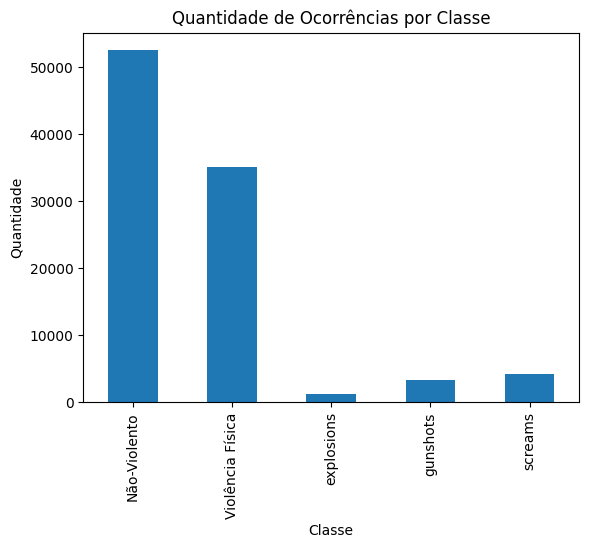

In [33]:
import matplotlib.pyplot as plt

# Configurações do gráfico
plt.figure(figsize=(12, 6))
df_agrupado.plot(x='Classe', y='Quantidade', kind='bar', legend=False)
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Quantidade de Ocorrências por Classe')

# Exibe o gráfico
plt.show()